In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform_ = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))])

train_dataset = datasets.MNIST(root="data/", download=False, train=True, transform=transform_)
test_dataset = datasets.MNIST(root="data/", download=False, train=False, transform=transform_)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [3]:
d = 28*28
d1 = 300
k = 10
num_epochs = 100
lr = 0.001

In [10]:
def initialize_weights(d, d1, k, random):
    if random:
        W1 = np.random.uniform(-1, 1, (d1, d))
        W2 = np.random.uniform(-1, 1, (k, d1))
    else:
        W1 = np.zeros((d1, d))
        W2 = np.zeros((k, d1))
    return W1, W2

def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(x):
    exp_x = np.exp(x-np.max(x, axis=-1, keepdims=True))
    return exp_x/exp_x.sum(axis=-1, keepdims=True)

In [11]:
W1, W2 = initialize_weights(d, d1, k, True)

In [12]:
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    loss_epoch = 0
    for image_b, label_b in train_loader:
        X_train = image_b.view(-1, d).numpy()
        Y_train = np.eye(k)[label_b.numpy()]
        
        Z1 = np.dot(W1, X_train.T)
        A1 = sigmoid(Z1)
        Z2 = np.dot(W2, A1)
        Y_out = softmax(Z2.T)
        
        dZ2 = Y_out-Y_train
        dW2 = np.dot(dZ2.T, A1.T)/(X_train.shape[0])
        dA1 = np.dot(dZ2, W2)
        dZ1 = dA1*A1.T*(1-A1.T)
        dW1 = np.dot(dZ1.T, X_train)/(X_train.shape[0])
        
        W1 -= lr*dW1
        W2 -= lr*dW2
        
        loss_epoch += (-np.sum(Y_train*np.log(Y_out), axis=1).mean())
    print(W1, W2)
    train_losses.append(loss_epoch/len(train_loader))
    print(f"Epoch {epoch}: Loss {train_losses[epoch]}")

[[-0.01244518  0.53018662  0.60855853 ...  0.99166675 -0.04830922
  -0.7475053 ]
 [-0.03553385  0.06760459 -0.9942599  ... -0.1244701   0.52830097
  -0.17186053]
 [ 0.72447797  0.39640584 -0.59360346 ...  0.55583208  0.21910077
  -0.99842526]
 ...
 [ 0.52305324  0.75772348  0.8389743  ...  0.15352746  0.53981489
   0.95124953]
 [ 0.9935501   0.86883588  0.69465069 ... -0.96981685  0.69867278
  -0.56005882]
 [-0.32880318  0.98007774 -0.95622725 ...  0.30774956  0.10252739
  -0.30686086]] [[ 0.27032412 -0.52808364 -0.29692862 ... -0.96878405  0.80919278
   0.14736644]
 [-0.12008124 -0.42792492 -0.84018729 ...  0.83727001  0.24679361
  -0.96320491]
 [-0.1735468   0.03955318 -0.82921049 ...  0.72893356 -0.96860269
   0.726821  ]
 ...
 [-0.55628006 -0.33227592 -0.41009605 ... -0.18638803  0.87904417
   0.88542189]
 [-0.08031703  0.54008741  0.39579254 ... -0.98450134  0.45529983
   0.6761208 ]
 [-0.99826573 -0.60660119 -0.52603012 ... -0.75312637  0.59385925
   0.10287931]]
Epoch 0: Loss 5.

In [13]:
test_error = 0
for image_b, label_b in test_loader:
    X_test = image_b.view(-1, d).numpy()
    Y_test = np.eye(k)[label_b.numpy()]
    
    A1 = sigmoid(np.dot(W1, X_test.T))
    Y_out = softmax(np.dot(W2, A1).T)
    
    test_error += (-np.sum(Y_test*np.log(Y_out), axis=1).mean())

In [15]:
test_error/len(test_loader)

0.36195053310762265

Text(0, 0.5, 'Train Loss')

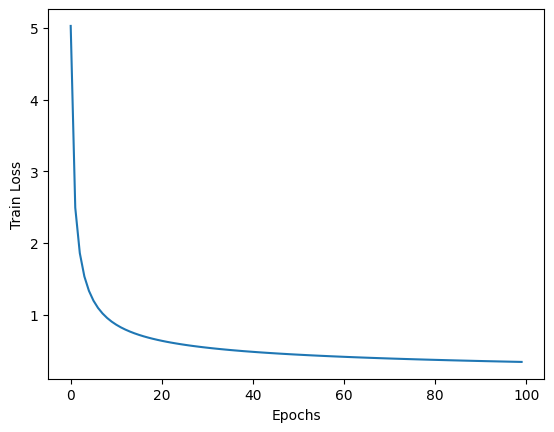

In [17]:
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

In [5]:
def init_weights_torch(layer):
    if type(layer) == torch.nn.Linear:
        #torch.nn.init.zeros_(layer.weight)
        torch.nn.init.uniform_(layer.weight, a=-1, b=1)

In [6]:
torch_model = torch.nn.Sequential(torch.nn.Linear(d, d1), torch.nn.Sigmoid(), torch.nn.Linear(d1, k))
torch_model.apply(init_weights_torch)

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=300, out_features=10, bias=True)
)

In [7]:
torch_model[2].weight

Parameter containing:
tensor([[ 0.3338,  0.2510, -0.0711,  ..., -0.3874,  0.4866,  0.1345],
        [ 0.8561, -0.0345,  0.9530,  ..., -0.0856,  0.5269,  0.7282],
        [ 0.3834, -0.9112,  0.3097,  ...,  0.8840,  0.6526,  0.7502],
        ...,
        [ 0.0847, -0.6782, -0.7868,  ...,  0.8133, -0.4661,  0.6132],
        [-0.1184, -0.6305,  0.4371,  ...,  0.8638,  0.2778,  0.5049],
        [ 0.5441, -0.4162, -0.1172,  ...,  0.6646, -0.9955, -0.5544]],
       requires_grad=True)

In [8]:
optimizer = torch.optim.SGD(torch_model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

training_torch_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for image_b, label_b in train_loader:
        X_train = image_b.view(image_b.shape[0], -1)
        
        optimizer.zero_grad()
        Y_out = torch_model(X_train)
        loss_cal = loss_func(Y_out, label_b)
        loss_cal.backward()
        optimizer.step()
        epoch_loss += loss_cal.item()
    training_torch_losses.append(epoch_loss/len(train_loader))
    print(training_torch_losses[epoch])

4.093805683199565
2.4498908735275267
1.8283844208717346
1.5005307708740234
1.3010077352364857
1.1673573489507039
1.0709345995426178
0.9978188319524129
0.9398980005264282
0.8923758204062779
0.8526509645064672
0.8183462752739589
0.788904681579272
0.7629283734401067
0.739459849301974
0.7187510678927104
0.6998802116235098
0.6828836134354274
0.6670921389897665
0.652554890080293
0.6392081583897272
0.6267256229956945
0.615123375638326
0.604336934574445
0.5942116542299588
0.5845275064071019
0.5755930976947149
0.5670708676298459
0.5590634629487992
0.5513610219915708
0.5439773638308049
0.5370162666837375
0.5303028467496236
0.5239650695800782
0.5178796673138937
0.5120788975596428
0.5064998149891694
0.5010896159688631
0.49593499276141323
0.49105563641786576
0.48633145645856857
0.48171447124878564
0.4772664206703504
0.4730451128363609
0.4689212522069613
0.4648866032719612
0.46105371316671373
0.45729426017999647
0.45370195982853573
0.45023520145018897
0.4467242587129275
0.44348717846969765
0.4402018

Text(0, 0.5, 'Training Loss')

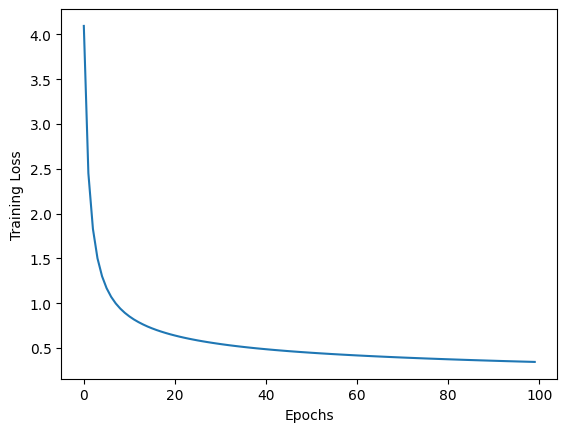

In [9]:
plt.plot(training_torch_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

In [10]:
test_error = 0
for image_b, label_b in test_loader:
    X_test = image_b.view(image_b.shape[0], -1)
    Y_test_out = torch_model(X_test)
    test_error += loss_func(Y_test_out, label_b).item()

In [11]:
test_error/len(test_loader)

0.356224957198952